# Modeling and Simulation in Python

Starter code for the orbit example

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [65]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

### Earth falling into the sun

Here's a question from the web site [Ask an Astronomer](http://curious.astro.cornell.edu/about-us/39-our-solar-system/the-earth/other-catastrophes/57-how-long-would-it-take-the-earth-to-fall-into-the-sun-intermediate):

"If the Earth suddenly stopped orbiting the Sun, I know eventually it would be pulled in by the Sun's gravity and hit it. How long would it take the Earth to hit the Sun? I imagine it would go slowly at first and then pick up speed."

Here's a solution.

In [66]:
# Here are the units we'll need

s = UNITS.second
N = UNITS.newton
kg = UNITS.kilogram
m = UNITS.meter

<Unit('meter')>

In [67]:
# And an inition condition (with everything in SI units)

r_0 = 147e9 * m

init = State(x = r_0 * m,
             y = 0 * m,
             vx = 0 * m / s,
             vy = -30330 * m / s, )

,values
x,147000000000.0 meter ** 2
y,0 meter
vx,0.0 meter / second
vy,-30330.0 meter / second


In [68]:
# Making a system object

r_earth = 6.371e6 * m
r_sun = 695.508e6 * m

system = System(init=init,
                G=6.674e-11 * N / kg**2 * m**2,
                m1=1.989e30 * kg,
                r_final=r_sun + r_earth,
                m2=5.972e24 * kg,
                t_0=0 * s,
                t_end=3.154e7 * s)

,values
init,x 147000000000.0 meter ** 2 y ...
G,6.674e-11 meter ** 2 * newton / kilogram ** 2
m1,1.989e+30 kilogram
r_final,701879000.0 meter
m2,5.972e+24 kilogram
t_0,0 second
t_end,31540000.0 second


In [69]:
# Here's a function that computes the force of gravity

def universal_gravitation(state, system):
    """Computes gravitational force.
    
    state: State object with distance r
    system: System object with m1, m2, and G
    """
    x, y, vx, vy = state
    unpack(system)
    
    pos = Vector(x, y)
    
    Fx, Fy = pol2cart(pos.angle, G * m1 * m2 / r_0**2) 
    
    force = Vector(Fx, Fy)
    
    return force

In [70]:
universal_gravitation(init, system)

<Quantity([3.6686486e+22 0.0000000e+00], 'newton')>

In [71]:
# The slope function

def slope_func(state, t, system):
    """Compute derivatives of the state.
    
    state: position, velocity
    t: time
    system: System object containing `g`
    
    returns: derivatives of y and v
    """
    x, y, vx, vy = state
    unpack(system)

    acc_grav = universal_gravitation(state, system) / m2
    
    dydt = Vector(vx, vy)
    dvdt = -acc_grav
    
    return dydt.x, dydt.y, dvdt.x, dvdt.y

In [72]:
# Always test the slope function!

slope_func(init, 0, system)

(<Quantity(0.0, 'meter / second')>,
 <Quantity(-30330.0, 'meter / second')>,
 <Quantity(-0.006143082049146188, 'newton / kilogram')>,
 <Quantity(-0.0, 'newton / kilogram')>)

In [21]:
# Here's an event function that stops the simulation
# before the collision

def event_func(state, t, system):
    r, v = state
    return r - system.r_final

In [ ]:
# Always test the event function!

event_func(init, 0, system)

In [73]:
# Finally we can run the simulation

results, details = run_ode_solver(system, slope_func)
details

,values
sol,None
t_events,[]
nfev,128
njev,0
nlu,0
status,0
message,The solver successfully reached the end of the...
success,True


In [74]:
# Here's how long it takes...

t_final = get_last_label(results) * s

<Quantity(31540000.0, 'second')>

In [75]:
# ... expressed in units we understand

t_final.to(UNITS.day)

<Quantity(365.04629629629625, 'day')>

In [76]:
# Before plotting, we run the simulation again with `t_eval`

ts = linspace(t_0, t_final, 400)
results, details = run_ode_solver(system, slope_func, t_eval=ts)

In [77]:
# Scaling the time steps to days

results.index /= 60 * 60 * 24

In [78]:
# Scaling the distance to million km

x = results.x / 1e9;
y = results.y / 1e9;

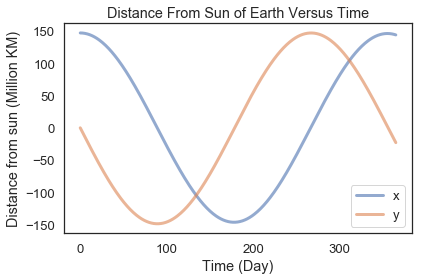

In [79]:
# And plotting

plot(x, label='x')
plot(y, label='y')

decorate(title='Distance From Sun of Earth Versus Time',
         xlabel='Time (Day)',
         ylabel='Distance from sun (Million KM)')

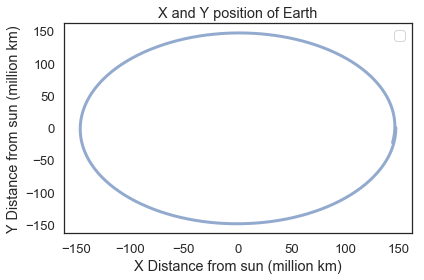

In [80]:
plot(x, y)
decorate(title='X and Y position of Earth',
         xlabel='X Distance from sun (million km)',
         ylabel='Y Distance from sun (million km)')

### Experimenting with solve_ivp

In [81]:
def run_ode_solver_v2(system, slope_func, **options):
    """Computes a numerical solution to a differential equation.

    `system` must contain `init` with initial conditions,
    `t_0` with the start time, and `t_end` with the end time.

    It can contain any other parameters required by the slope function.

    `options` can be any legal options of `scipy.integrate.solve_ivp`

    system: System object
    slope_func: function that computes slopes

    returns: TimeFrame
    """
    # make sure `system` contains `init`
    if not hasattr(system, 'init'):
        msg = """It looks like `system` does not contain `init`
                 as a system variable.  `init` should be a State
                 object that specifies the initial condition:"""
        raise ValueError(msg)

    # make sure `system` contains `t_end`
    if not hasattr(system, 't_end'):
        msg = """It looks like `system` does not contain `t_end`
                 as a system variable.  `t_end` should be the
                 final time:"""
        raise ValueError(msg)

    # make the system parameters available as globals
    unpack(system)

    # the default value for t_0 is 0
    t_0 =  getattr(system, 't_0', 0)

    # try running the slope function with the initial conditions
    # try:
    #     slope_func(init, t_0, system)
    # except Exception as e:
    #     msg = """Before running scipy.integrate.solve_ivp, I tried
    #              running the slope function you provided with the
    #              initial conditions in `system` and `t=t_0` and I got
    #              the following error:"""
    #     logger.error(msg)
    #     raise(e)

    # wrap the slope function to reverse the arguments and add `system`
    f = lambda t, y: slope_func(y, t, system)

    def wrap_event(event):
        """Wrap the event functions.

        Make events terminal by default.
        """
        wrapped = lambda t, y: event(y, t, system)
        wrapped.terminal = getattr(event, 'terminal', True)
        wrapped.direction = getattr(event, 'direction', 0)
        return wrapped

    # wrap the event functions so they take the right arguments
    events = options.pop('events', [])
    try:
        events = [wrap_event(event) for event in events]
    except TypeError:
        events = wrap_event(events)

    # remove dimensions from the initial conditions.
    # we need this because otherwise `init` gets copied into the
    # results array along with its units
    y_0 = [magnitude(x) for x in init]

    # run the solver
    with units_off():
        bunch = solve_ivp(f, [t_0, t_end], y_0, method='RK45', events=events, **options)

    # separate the results from the details
    y = bunch.pop('y')
    t = bunch.pop('t')
    details = ModSimSeries(bunch)

    # pack the results into a TimeFrame
    results = TimeFrame(np.transpose(y), index=t, columns=init.index)
    return results, details

In [82]:
# Before plotting, we run the simulation again with `t_eval`

ts = linspace(t_0, t_final, 400)
results, details = run_ode_solver_v2(system, slope_func, t_eval=ts)

In [83]:
# Scaling the time steps to days

results.index /= 60 * 60 * 24

In [84]:
# Scaling the distance to million km

x = results.x / 1e9;
y = results.y / 1e9;

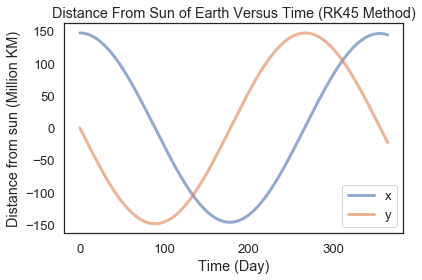

In [88]:
# And plotting

plot(x, label='x')
plot(y, label='y')

decorate(title='Distance From Sun of Earth Versus Time (RK45 Method)',
         xlabel='Time (Day)',
         ylabel='Distance from sun (Million KM)')

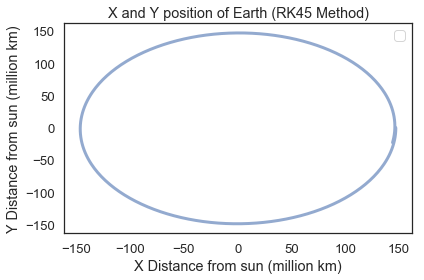

In [90]:
plot(x, y)
decorate(title='X and Y position of Earth (RK45 Method)',
         xlabel='X Distance from sun (million km)',
         ylabel='Y Distance from sun (million km)')